In [32]:
# import libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from pathlib import Path
import os
import seaborn as sns
import datetime
import shapely
from shapely.geometry import shape, Point, LineString, Polygon

# set the working directory
BASE_DIR = Path.cwd()
print(BASE_DIR)

#set the project directory
project_folder = BASE_DIR.parent.parent
print(project_folder)

/tmp/pycharm_project_316/BEAM_Freight/Notebooks/GCE
/tmp/pycharm_project_316/BEAM_Freight


In [33]:
# Upload output in the respective bucket storage in the following path
# "gs://beam-core-outputs/output/city_name/simulation_name/Output/*" or
# "gs://beam-core-outputs/output/city_name/simulation_name/Output/plot/*" or

from google.cloud import storage
# Upload file to Google Cloud service
def upload_blob(_bucket_name, _source_file_name, _destination_blob_name):
    """Uploads a file to the bucket."""
    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"
    # The path to your file to upload
    # source_file_name = "local/path/to/file"
    # The ID of your GCS object
    # destination_blob_name = "storage-object-name"
    storage_client = storage.Client()
    bucket = storage_client.bucket(_bucket_name)
    blob = bucket.blob(_destination_blob_name)
    # Optional: set a generation-match precondition to avoid potential race conditions
    # and data corruptions. The request to upload is aborted if the object's
    # generation number does not match your precondition. For a destination
    # object that does not yet exist, set the if_generation_match precondition to 0.
    # If the destination object already exists in your bucket, set instead a
    # generation-match precondition using its generation number.
    generation_match_precondition = 0
    blob.upload_from_filename(_source_file_name, if_generation_match=generation_match_precondition)
    print(
        f"File {_source_file_name} uploaded to {_destination_blob_name}."
    )

def delete_blob(_bucket_name, _blob_name):
    """Deletes a blob from the bucket."""
    # bucket_name = "your-bucket-name"
    # blob_name = "your-object-name"

    storage_client = storage.Client()

    bucket = storage_client.bucket(_bucket_name)
    blob = bucket.blob(_blob_name)
    generation_match_precondition = None

    # Optional: set a generation-match precondition to avoid potential race conditions
    # and data corruptions. The request to delete is aborted if the object's
    # generation number does not match your precondition.
    blob.reload()  # Fetch blob metadata to use in generation_match_precondition.
    generation_match_precondition = blob.generation

    blob.delete(if_generation_match=generation_match_precondition)

    print(f"Blob {_blob_name} deleted.")

In [34]:
# Basic Reference Points
city_name="austin"
gcloud_bucket = "gs://beam-core-outputs/output/austin"
iter_no = "0"
linkstats_file_path = f"{iter_no}.linkstats.csv.gz"
network_file_path = "network.csv.gz"
event_files_path = f"{iter_no}.events.csv.gz"
simulation_name = "austin-base-with-freight-2018__2023-04-14_16-11-13_yoq"
analysis_type = "Freight"
#Check if the folder exist, if not create it.
try:
    pathlib.Path(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot")).mkdir(parents=True, exist_ok=False)
except:
    pass

# conversion units
meter_to_mile = 0.000621371
percent_of_samples = 0.5
mps_to_mph = 2.23694

In [35]:
# load austin radar data for validation
austin_radar_data = pd.read_csv(project_folder.joinpath("Reference_Data",city_name,"RADAR", "Radar_Traffic_Counts.csv"))
# post-process radar data and assign attributes
austin_radar_data.loc[:, 'datetime'] = austin_radar_data.loc[:,'Read Date'].str[:-6]
austin_radar_data.loc[:,'date_dt'] = pd.to_datetime(austin_radar_data.loc[:,'datetime'], format='%m/%d/%Y  %I:%M:%S %p', errors = 'coerce')
austin_radar_data = austin_radar_data.loc[austin_radar_data['date_dt'] != 'NaT']
austin_radar_data.loc[:,'date_formatted'] = austin_radar_data.loc[:,'date_dt'].dt.date
austin_radar_data.loc[:,'hour_formatted'] = austin_radar_data.loc[:,'date_dt'].dt.hour
austin_radar_data = austin_radar_data.loc[austin_radar_data['KITS ID'] != 18]
austin_radar_data["Year"] = austin_radar_data["Year"].astype(int)

In [36]:
# select observed data for validation
austin_radar_data_validation = austin_radar_data.loc[austin_radar_data["Year"] == 2018]
austin_radar_data_validation = austin_radar_data_validation.loc[austin_radar_data_validation["Day of Week"]<=5]
austin_radar_data_validation.loc[austin_radar_data_validation['Speed']>= 80, 'Speed'] = 80
austin_radar_data_validation.loc[:, 'Volume'] *= 4 # convert 15-min volume to hourly
austin_radar_data_hourly_volume = austin_radar_data_validation.groupby(['KITS ID', 'Hour'])[['Volume']].mean()
austin_radar_data_hourly_volume.columns = ['Volume (veh/lane/hour)']
austin_radar_data_hourly_volume = austin_radar_data_hourly_volume.reset_index()
austin_radar_data_hourly_speed = austin_radar_data_validation.groupby(['KITS ID', 'Hour']).apply(lambda x: np.average(x.Speed, weights=x.Volume))
austin_radar_data_hourly_speed = austin_radar_data_hourly_speed.reset_index()
austin_radar_data_hourly_speed.columns = ['KITS ID', 'Hour', 'Avg.Speed (mph)']

austin_radar_data_hourly_data = pd.merge(austin_radar_data_hourly_volume,
                                         austin_radar_data_hourly_speed,
                                         on = ['KITS ID', 'Hour'], how = 'left')

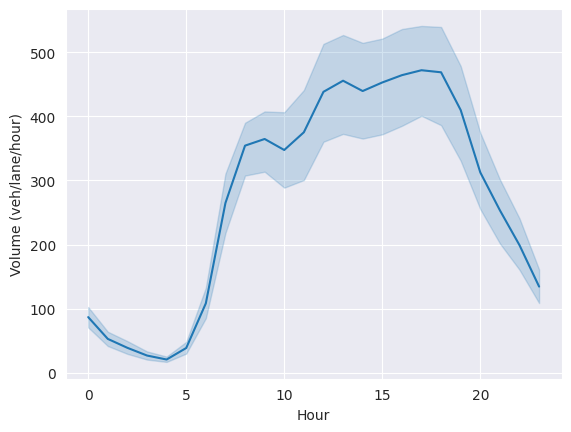

Blob output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_observed_hourly_mean_volume.png deleted.
File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_observed_hourly_mean_volume.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_observed_hourly_mean_volume.png.


In [37]:
# Graph: Time vs Hourly Volume (per lane)
sns.lineplot(data = austin_radar_data_hourly_data, x = "Hour", y = "Volume (veh/lane/hour)", errorbar=('ci',95))
# plt.ylim([0, 70])
# plt.ylabel('average speed (mph)')
plt_file_name = "Austin_observed_hourly_mean_volume.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot", plt_file_name), bbox_inches='tight', dpi = 600)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"

# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

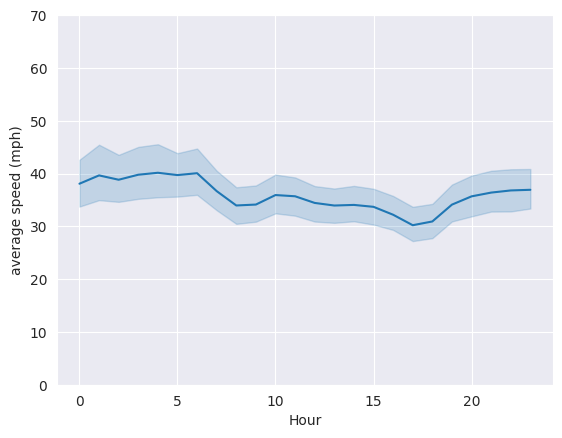

Blob output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_observed_hourly_mean_speed.png deleted.
File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_observed_hourly_mean_speed.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_observed_hourly_mean_speed.png.


In [38]:
# Graph: Time vs Average Speed
sns.lineplot(data = austin_radar_data_hourly_data, x = "Hour", y = "Avg.Speed (mph)", errorbar=('ci',95))
plt.ylim([0, 70])
plt.ylabel('average speed (mph)')
plt_file_name = "Austin_observed_hourly_mean_speed.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot", "Austin_observed_hourly_mean_speed.png"), bbox_inches='tight', dpi = 600)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"

# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

In [39]:
# load BEAM output
modeled_vmt = pd.read_csv(f"{gcloud_bucket}/{simulation_name}/ITERS/it.{iter_no}/{linkstats_file_path}", compression="gzip", low_memory=True)
model_network = pd.read_csv(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, 'BEAM_network_screenlines.csv'), low_memory=False)
model_network = model_network.drop_duplicates(subset=['linkId'])

In [40]:
# filter modeled network
model_vmt_24_hour = modeled_vmt.loc[(modeled_vmt['hour'] <= 28) & (modeled_vmt['hour'] >= 5)]
model_vmt_24_hour.loc[model_vmt_24_hour['hour']>=24, 'hour'] -= 24
model_network['fromNodeId'] = model_network['fromNodeId'].astype(int)
model_network['toNodeId'] = model_network['toNodeId'].astype(int)
model_vmt_24_hour = pd.merge(model_vmt_24_hour, model_network,
                             left_on = ['link', 'from', 'to'],
                             right_on = ['linkId', 'fromNodeId', 'toNodeId'], how = 'inner')

model_vmt_24_hour = model_vmt_24_hour.rename(columns = {'length_x': 'length_raw',
                                                        'length_y': 'length_adj'})

In [41]:
demand_scaling = 1/percent_of_samples
model_vmt_24_hour.loc[:, 'hourly volume'] = model_vmt_24_hour.loc[:, 'volume']/ \
                                            model_vmt_24_hour.loc[:, 'numberOfLanes']
model_vmt_24_hour.loc[:, 'VMT'] = demand_scaling * meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
# model_vmt_24_hour.loc[:, 'travel_time (hr)'] = model_vmt_24_hour.loc[:, 'linkLength'] /3600
model_vmt_24_hour.loc[:, 'speed'] = model_vmt_24_hour.loc[:, 'linkLength'] / model_vmt_24_hour.loc[:, 'traveltime']
model_vmt_24_hour.loc[:, 'speed (mph)'] = mps_to_mph * model_vmt_24_hour.loc[:, 'speed']

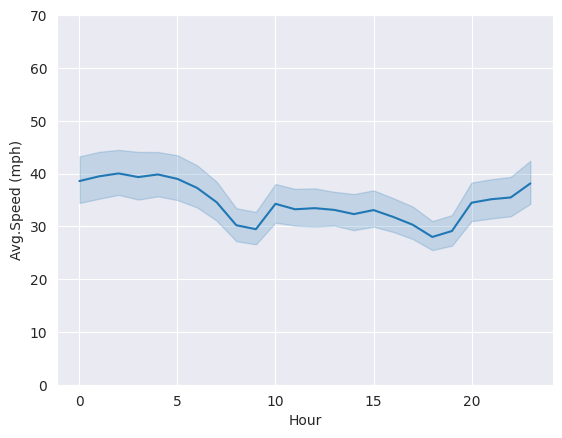

Blob output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_modeled_speed_screenline.png deleted.
File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_modeled_speed_screenline.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_modeled_speed_screenline.png.


In [42]:
model_vmt_hour_volume = model_vmt_24_hour.groupby(['KITS_ID', 'hour'])[['hourly volume']].mean()
model_vmt_hour_volume = model_vmt_hour_volume.reset_index()
model_vmt_hour_volume.columns = ['KITS ID', 'Hour', 'Volume (veh/lane/hour)']
model_vmt_24_hour_filtered = model_vmt_24_hour.loc[model_vmt_24_hour['volume']>0]
model_vmt_hour_speed = model_vmt_24_hour_filtered.groupby(['KITS_ID', 'hour']).apply(lambda x: np.average(x.speed, weights=x.volume))
model_vmt_hour_speed = model_vmt_hour_speed.reset_index()
model_vmt_hour_speed.columns = ['KITS ID', 'Hour', 'Avg.Speed (mph)']
model_vmt_hour_speed.loc[:, 'Avg.Speed (mph)'] *= mps_to_mph

model_vmt_hour_data = pd.merge(model_vmt_hour_volume, model_vmt_hour_speed,
                               on = ['KITS ID', 'Hour'], how = 'left')
sns.lineplot(x = 'Hour', y = 'Avg.Speed (mph)', data = model_vmt_hour_data, errorbar=('ci',95))
plt.ylim([0, 70])
plt_file_name = "Austin_modeled_speed_screenline.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot", plt_file_name), dpi = 600)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"

# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

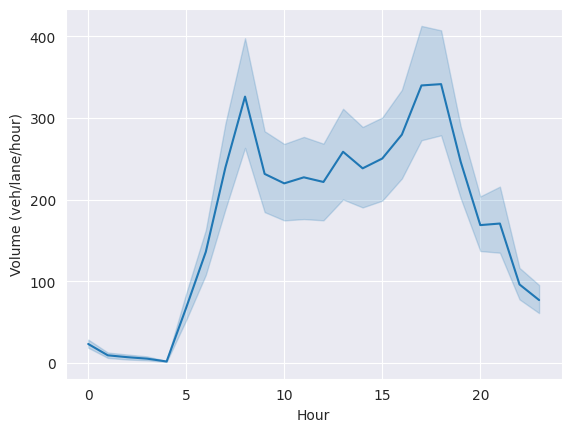

Blob output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_modeled_volume_screenline.png deleted.
File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_modeled_volume_screenline.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_modeled_volume_screenline.png.


In [43]:
sns.lineplot(x = 'Hour', y = 'Volume (veh/lane/hour)', data = model_vmt_hour_data, errorbar=('ci',95))
# plt.ylim([0, 70])
# plt.ylabel('volume (veh/lane/hour)')
plt_file_name = "Austin_modeled_volume_screenline.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot", plt_file_name), dpi = 600)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"

# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

In [44]:
# compare two datasets
austin_radar_data_hourly_data.loc[:, 'source'] = 'Austin radar data'
model_vmt_hour_data.loc[:, 'source'] = 'BEAM output'
combined_data = pd.concat([austin_radar_data_hourly_data, model_vmt_hour_data])
combined_data = combined_data.reset_index()

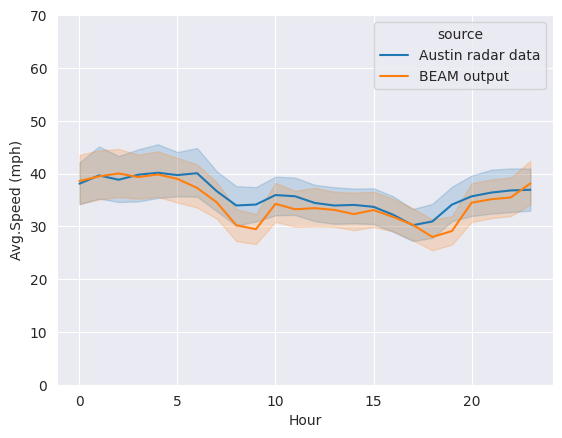

Blob output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/BEAM_screenline_speed_validation.png deleted.
File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/BEAM_screenline_speed_validation.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/BEAM_screenline_speed_validation.png.


In [45]:
sns.lineplot(x = 'Hour', y = 'Avg.Speed (mph)', hue = 'source', data = combined_data, errorbar=('ci',95))
plt.ylim([0, 70])
plt_file_name = "BEAM_screenline_speed_validation.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot", plt_file_name), dpi = 600)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"

# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

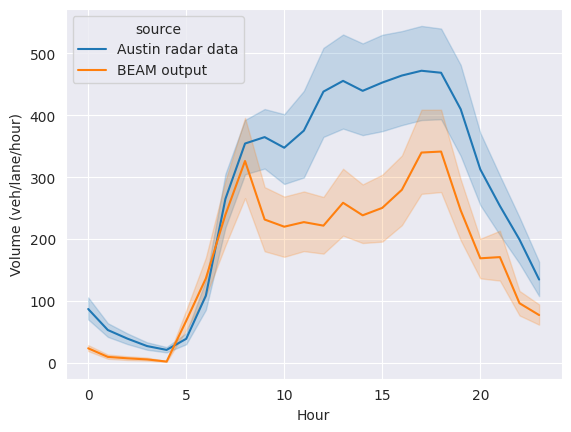

Blob output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_BEAM_screenline_volume_validation.png deleted.
File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_BEAM_screenline_volume_validation.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_BEAM_screenline_volume_validation.png.


In [46]:
sns.lineplot(x = 'Hour', y = 'Volume (veh/lane/hour)', hue = 'source', data = combined_data, errorbar=('ci',95))
# plt.ylim([0, 70])
# plt.ylabel('volume (veh/lane/hour)')
plt_file_name = "Austin_BEAM_screenline_volume_validation.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot", plt_file_name), dpi = 600)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"

# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

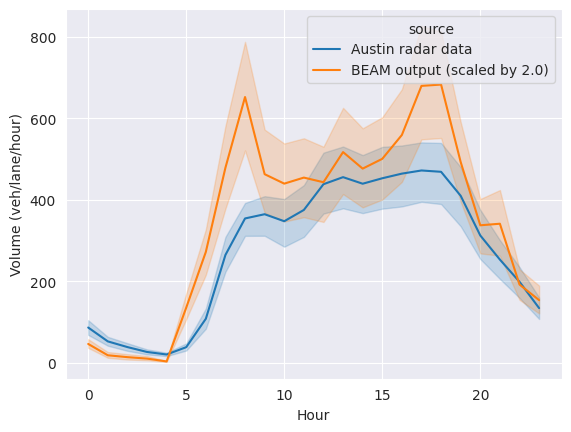

Blob output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_BEAM_screenline_scaled_volume_validation.png deleted.
File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_BEAM_screenline_scaled_volume_validation.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_BEAM_screenline_scaled_volume_validation.png.


In [47]:
model_vmt_hour_data_scaled = model_vmt_hour_data.copy()
model_vmt_hour_data_scaled.loc[:, 'Volume (veh/lane/hour)'] *= demand_scaling
model_vmt_hour_data_scaled.loc[:, 'source'] = f'BEAM output (scaled by {demand_scaling})'
#model_vmt_hour_data.loc[:, 'source'] = 'BEAM output'
combined_data_scaled = pd.concat([austin_radar_data_hourly_data, model_vmt_hour_data_scaled])
combined_data_scaled = combined_data_scaled.reset_index()
combined_data_scaled.head(5)
sns.lineplot(x = 'Hour', y = 'Volume (veh/lane/hour)', hue = 'source',
             data = combined_data_scaled, errorbar=('ci',95))
# plt.ylim([0, 70])
# plt.ylabel('volume (veh/lane/hour)')
plt_file_name = "Austin_BEAM_screenline_scaled_volume_validation.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot", plt_file_name), dpi = 600)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"

# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

In [48]:
paired_data_for_comparison = pd.merge(austin_radar_data_hourly_data, model_vmt_hour_data,
                                      on = ['KITS ID', 'Hour'], how = 'left')
paired_data_for_comparison = paired_data_for_comparison.rename(columns = {'Avg.Speed (mph)_x': 'Austin radar speed',
                                                                          'Avg.Speed (mph)_y': 'BEAM speed',
                                                                          'Volume (veh/lane/hour)_x': 'Austin radar volume',
                                                                          'Volume (veh/lane/hour)_y': 'BEAM volume'})
paired_data_for_comparison["KITS ID"] = paired_data_for_comparison["KITS ID"].astype(str)

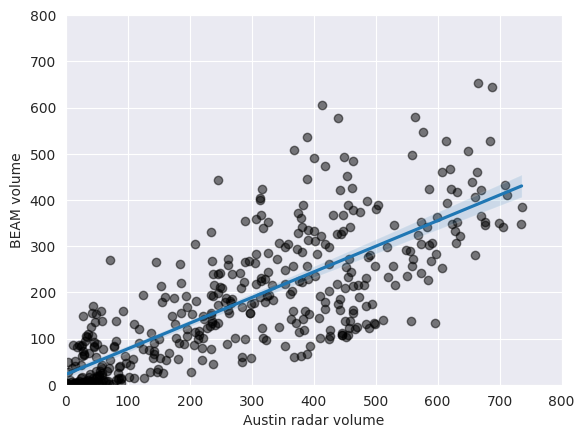

Blob output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_paired_screenline_volume_validation.png deleted.
File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_paired_screenline_volume_validation.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_paired_screenline_volume_validation.png.


In [49]:
sns.regplot(data=paired_data_for_comparison, x="Austin radar volume", y="BEAM volume",
            scatter_kws={"color": "black", 'alpha':0.5})
plt.xlim([0, 800])
plt.ylim([0, 800])
plt_file_name = "Austin_paired_screenline_volume_validation.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot", plt_file_name), dpi = 600)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"

# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

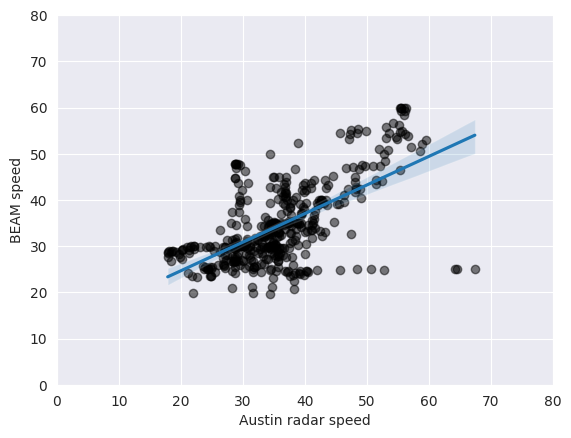

Blob output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_paired_screenline_speed_validation.png deleted.
File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_paired_screenline_speed_validation.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_paired_screenline_speed_validation.png.


In [50]:
sns.regplot(data=paired_data_for_comparison, x="Austin radar speed", y="BEAM speed",
            scatter_kws={"color": "black", 'alpha':0.5})
plt.xlim([0, 80])
plt.ylim([0, 80])
plt_file_name = "Austin_paired_screenline_speed_validation.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot", plt_file_name), dpi = 600)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"

# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

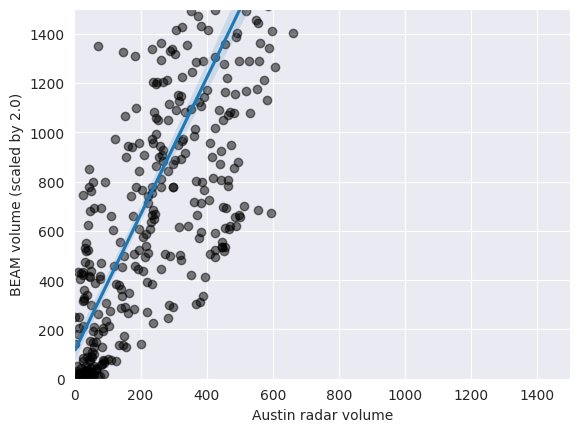

Blob output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_paired_screenline_scaled_volume_validation.png deleted.
File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/Austin_paired_screenline_scaled_volume_validation.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/Austin_paired_screenline_scaled_volume_validation.png.


In [51]:
paired_data_for_comparison.loc[:, f'BEAM volume (scaled by {demand_scaling})'] = paired_data_for_comparison.loc[:, 'BEAM volume'] * 5
sns.regplot(data=paired_data_for_comparison, x="Austin radar volume", y= f'BEAM volume (scaled by {demand_scaling})',
            scatter_kws={"color": "black", 'alpha':0.5})
plt.xlim([0, 1500])
plt.ylim([0, 1500])
plt_file_name = "Austin_paired_screenline_scaled_volume_validation.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot", plt_file_name), dpi = 600)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"

# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

In [52]:
model_network_with_observed_traffic = pd.merge(model_network, austin_radar_data_hourly_data,
                                               left_on = 'KITS_ID', right_on = 'KITS ID', how = 'left')
model_network_with_observed_traffic.loc[:, 'Volume(veh/hour)'] = model_network_with_observed_traffic.loc[:, 'Volume (veh/lane/hour)'] * \
                                                                 model_network_with_observed_traffic.loc[:, 'numberOfLanes']
list_of_out_var = ['linkId', 'linkLength', 'linkFreeSpeed', 'linkCapacity',
                   'numberOfLanes', 'linkModes', 'attributeOrigId',
                   'attributeOrigType', 'fromNodeId', 'toNodeId', 'name',
                   'Hour', 'Avg.Speed (mph)', 'Volume(veh/hour)', 'source']
model_network_with_observed_traffic = model_network_with_observed_traffic.loc[:, list_of_out_var]

df_file_name = "Austin_2010_observed_data_for_validation_part_1.csv"
model_network_with_observed_traffic.to_csv(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, df_file_name), index = False)

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, df_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/{df_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

Blob output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/Austin_2010_observed_data_for_validation_part_1.csv deleted.
File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/Austin_2010_observed_data_for_validation_part_1.csv uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/Austin_2010_observed_data_for_validation_part_1.csv.
